# RAG for Grammar Books
Notebook to retrieve linguistic information from grammar books

Basic Overview of RAG using LangChain can be found here:\
https://python.langchain.com/docs/tutorials/rag/

https://python.langchain.com/docs/concepts/ \
https://github.com/langchain-ai/rag-from-scratch

**VectorStore Info**\
https://python.langchain.com/docs/how_to/vectorstores/ \
https://python.langchain.com/docs/integrations/vectorstores/chroma/#query-by-turning-into-retriever

**API Reference**\
https://python.langchain.com/api_reference/


### Do imports

In [1]:
import os
from langchain_community.document_loaders import PyPDFLoader, TextLoader
# from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_community.vectorstores import Chroma
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
# from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chains.combine_documents import create_stuff_documents_chain
# from langchain.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain

USER_AGENT environment variable not set, consider setting it to identify your requests.


Specify grammar book to use and the OpenAI API key

In [2]:
DOC_PATH = "./resources/kalamang/kalamang-grammar.pdf"
CHROMA_PATH = "db_name"
OPENAI_API_KEY = "put-key-here"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
LANGCHAIN_API_KEY = "put-key-here"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY

## Use this for PDF files
Currently it's splitting on pages in the pdf document

In [32]:
loader = PyPDFLoader(DOC_PATH)
pages = loader.load()

# text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
# chunks = text_splitter.split_documents(pages)

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
# db_chroma = Chroma.from_documents(chunks, embeddings, persist_directory=CHROMA_PATH)
db_chroma = Chroma.from_documents(documents=pages, collection_name="lang_db", embedding=embeddings, persist_directory=CHROMA_PATH)

In [31]:
# Test loading the database
embedding_db = Chroma(collection_name="lang_db",
                      embedding_function=embeddings,
                      persist_directory=CHROMA_PATH
)

new_retriever = embedding_db.as_retriever(search_kwargs={'k': 2})
docs = new_retriever.invoke("What is the basic sentence structure of the language? Does it use subject-verb-object or aubject-object-verb")
len(docs)

NameError: name 'embeddings' is not defined

In [6]:
docs[1]

Document(metadata={'page': 337, 'source': './resources/kalamang/kalamang-grammar.pdf'}, page_content='12 The clause\n12.6 Variation in clausal structure\nTwocommonpatternsofvariationapplytoKalamangclausalstructure.Thefirst\nis elision of arguments, and the second is reordering of constituents to mark\ntopics and anti-topics. Arguments that are retrievable from the context may be\nelided, especially in dialogues. This is described in § 12.6.1. The marking of topic\nand anti-topic is described in § 12.6.2.\n12.6.1 Elision of arguments\nIn natural spoken Kalamang, when retrievable from the context, either the sub-\nject or the object may be elided, depending on which stays the same across\nclauses or utterances.\nAn example of subject elision is given in ( 116). The first clause contains both\nsubjectandobject.Theobjectandpredicatearerepeatedinthenextclauseasan\ninstance of tail-head linkage (§ 15.1.3). In the second and third clause, the subject\nis elided.\n(116)Mu\nmu\n3plhe\nse\niamer

In [7]:
# Test retrieval
retriever = db_chroma.as_retriever(search_type="mmr", search_kwargs={"k": 2})

docs = retriever.invoke("What is the basic sentence structure of the language? Does it use subject-verb-object or aubject-object-verb")


In [8]:
docs[1]

Document(metadata={'page': 117, 'source': './resources/kalamang/kalamang-grammar.pdf'}, page_content='3 Phonetics, phonology and morphophonology\n(a) Focused subject\n (b) Neutral subject\nFigure 3.17 :Intonation of a clause with a focused subject and with a\nneutral subject\n(a) Focused object\n (b) Neutral object\nFigure 3.18 :Intonation of a clause with a focused object and with a\nneutral object\n(a) Focused verb\n (b) Neutral verb\nFigure 3.19 :Intonation of a clause with a focused verb and with a neu-\ntral verb\n94')

## Use this for text documents
 - Skipping for now

In [3]:
TEXT_DOC_PATH = "./resources/kalamang/grammar_book_long.txt"

# with open(TEXT_DOC_PATH) as f:
#     book = f.read()

loader = TextLoader(TEXT_DOC_PATH)
pages = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 100,
    length_function = len,
    is_separator_regex=False
)

chunks = text_splitter.split_documents(pages)

# loader = PyPDFLoader(DOC_PATH)
# pages = loader.load()

# text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
# chunks = text_splitter.split_documents(texts)

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
db_chroma = Chroma.from_documents(chunks, embeddings, persist_directory=CHROMA_PATH)

## Combined PDF and Text Loader
Performs the following on all pdf and txt files in a resource directory
- Load
- Split/Chunk
- Store

SKIPPING FOR NOW. Just using the PDF for prototyping.

In [16]:
directory = "./resources/kalamang"
documents = []
for file in os.listdir(directory):
    if file.endswith(".pdf"):
        pdf_path = os.path.join(directory, file)
        loader = PyPDFLoader(pdf_path)
        documents.extend(loader.load())
    elif file.endswith(".txt"):
        txt_path = os.path.join(directory, file)
        loader = TextLoader(txt_path)
        documents.extend(loader.load())

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 2000,
    chunk_overlap = 200,
    length_function = len,
    is_separator_regex=False
)

chunked_documents = text_splitter.split_documents(documents)
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
db_chroma = Chroma.from_documents(chunks, embeddings, persist_directory=CHROMA_PATH)

In [50]:
# Play area to inspect load, split, and index
# len(documents[0].page_content)
embeddings

OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x12c68e810>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x12f0045f0>, model='text-embedding-ada-002', dimensions=None, deployment='text-embedding-ada-002', openai_api_version='', openai_api_base=None, openai_api_type='', openai_proxy='', embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True)

---
## Perform Retrieval

This does simple retrieval from the vector database.

In [4]:
retriever = db_chroma.as_retriever()
prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI()

def format_pages(pages):
    return "\n\n".join(page.page_content for page in pages)


rag_chain = (
    {"context": retriever | format_pages, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is the basic sentence structure of the language? Does it use subject-verb-object or aubject-object-verb or something else?")

/Users/jonhus/vs-code/grammar-rag/venv/lib/python3.12/site-packages/langsmith/client.py:5301: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


'The basic sentence structure of the language is subject-object-verb in a transitive clause. Arguments precede the predicate in Kalamang. The object is marked with =at at the end of the object noun phrase.'

## Perform Retrievel - Showing Sources
#### This time showing documents in the context
Based on this:
https://python.langchain.com/docs/how_to/qa_sources/

Useful API docs:

https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.stuff.create_stuff_documents_chain.html

In [5]:
retriever = db_chroma.as_retriever()
llm = ChatOpenAI()

system_prompt = (
    "You are an assistant for question-answering tasks."
    "Use the following pieces of retrieved context to answer "
    "the question. Use three sentences maximum."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, prompt)
new_rag_chain = create_retrieval_chain(retriever, question_answer_chain)

# Returns a dict with 'input', 'context', 'answer'
result = new_rag_chain.invoke({"input": "What is the basic sentence structure of the language? Does it use subject-verb-object or aubject-object-verb or something else?"})
print(result['answer'])

The basic and unmarked transitive clause structure in Kalamang is subject-object-verb, with nominative-accusative alignment. Subject and object are differentiated by constituent order and object marking. In ditransitive clause constructions, the constituent order can vary as agent-theme-recipient-verb or agent-recipient-theme-verb.


The "context" in the returned result contains a list of Documents. Each Document contains metadata and content

https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html

In [7]:
result

{'input': 'What is the basic sentence structure of the language? Does it use subject-verb-object or aubject-object-verb or something else?',
 'context': [Document(metadata={'source': './resources/kalamang/grammar_book_long.txt'}, page_content='All arguments precede the predicate. The constituent orderconstituent order in a basic and unmarked transitive clause is subject-object-verb, with nominative-accusative alignmentalignmentaccusativeseealignment.\nA simplified template of the clause structure is given in (). A large number of clausal modifiers, including aspect, mood, modal markers and adverbials, occur in different slots in the clause and are described in Chapter . Many adverbials, aspect markers and mood markers attach to the predicate. The predicate can be complex and is, except in Chapter , discussed in Chapter and Chapter . In this chapter, I focus on simple verbal and non-verbal predicates.\nclause structure\n(Subj NP) (Obj NP=obj) (Indirect Obj NP) Pred\nSubject and object a

In [6]:
print(f"The answer used {len(result['context'])} sources.\n")

for document in result["context"]:
    print(document.metadata)
    print(document.page_content[0:60])
    print()

The answer used 4 sources.

{'source': './resources/kalamang/grammar_book_long.txt'}
All arguments precede the predicate. The constituent orderco

{'source': './resources/kalamang/grammar_book_long.txt'}
Ditransitive clause constructions
Showing and sending
The fi

{'source': './resources/kalamang/grammar_book_long.txt'}
'My wife's mistake doesn't matter.' 
Variation in clausal st

{'source': './resources/kalamang/grammar_book_long.txt'}
I start with a description of the major open word classes: v



## Test Questions to Run on Chains

This section contains a number of questions that we'd like to be able to answer using grammar books.

<code>rag_chain</code> takes the question as an argument.\
<code>new_rag_chain</code> takes a dict as an argument.

In [117]:
question = "What is the basic sentence structure of the language? Does it use subject-verb-object or aubject-object-verb"
response = rag_chain.invoke(question)
print(response)

The language uses the basic sentence structure with the order of agent-theme-recipient-verb or agent-recipient-theme-verb. Arguments can be elided in natural spoken Kalamang when retrievable from the context. Subject elision is possible in dialogues when the subject has been mentioned by another speaker.


In [22]:
rag_chain.invoke("How are plural forms of nouns constructed?")

"Plural forms of nouns can be constructed through reduplication, where some nouns may be reduplicated to indicate plurality. However, not all nouns can be reduplicated to form a plural, and the ones that can do not necessarily need to be reduplicated to show plurality. For example, 'pes' becomes 'pespes' for 'peels; skins; leftovers after peeling'."

In [92]:
new_rag_chain.invoke({"input": "How are plural forms of nouns constructed?"})

{'input': 'How are plural forms of nouns constructed?',
 'context': [Document(metadata={'source': './resources/kalamang/grammar_book_long.txt'}, page_content="Derivation of plural nounsplural!nominalnoun derivation!plural\nThough plurality of nominal referents is not obligatorily expressed on nouns, some nouns may be reduplicated to that effect. Most nouns cannot be reduplicated to form a plural, and those that can need not be reduplicated to have a plural referent. plural!nominal\npes 'peel; skin' → pespes 'peels; skins; leftovers after peeling'\nlempuang 'island' → lempuangpuang 'islands'\ntumun 'child' → tumtum 'children'\nDistributivitynoun derivation!distributivedistributive\nReduplication of nouns that refer to a location can be used to indicate distributivity. () and () are from recordings about where certain plants can be found. () has a reduplicated oskeit 'beach' (from os 'sand' and keit 'top'), as well as a reduplicated verb kos 'to grow' to indicate distribution or habitual

In [24]:
rag_chain.invoke("Does Kalamang contain definite and indefinite articles?")

'No, Kalamang does not contain definite and indefinite articles. The translations in the examples are based on context rather than specific articles. The NP in Kalamang is left-headed, with nominal possessors preceding the possessum.'

In [25]:
rag_chain.invoke("How are negations formed in sentences in Kalamang?")

'Negations in sentences in Kalamang are formed by using the suffix "-utak" in the quantifying paradigm for different pronouns. The negation suffix "-utak" is added to the pronouns in order to indicate negation in the sentence. The basic pronoun paradigms in Kalamang include singular, dual, and plural forms with specific suffixes indicating negation.'

In [31]:
rag_chain.invoke("Show an example of a negation of a sentence in Kalamang that uses the suffix '-utak'.")

"An example of a negation in Kalamang using the suffix '-utak' is 'inggaruokutak' which means 'only us three'. Dual forms in Kalamang cannot be suffixed with '-hutak', only with '-tak'. Forms like 'inggaruokutak' and 'inggansuortak' provide specificity on the number of people present."

In [42]:
rag_chain.invoke({"input": "What does -ahutak mean?"})

{'input': 'What does -ahutak mean?',
 'context': [Document(metadata={'page': 216, 'source': './resources/kalamang-grammar.pdf'}, page_content='[elic_pro_10]\nNote also that the -(a)hutak forms seem to include the clitic =tak‘just, only’.\nDual forms cannot be suffixed with -(a)hutak , only with -tak, e.g.iniertak means\n‘only us two’. Perhaps these forms are comparable to the -(a)hutak forms. The\ndual forms with -takgive the speaker the possibility to specify that there were\nonly two people, no more, no less. Forms like * inggaruoktak ‘only us three’ and\n*inggansuortak ‘only us four’ are not found in the corpus.'),
  Document(metadata={'page': 216, 'source': './resources/kalamang/kalamang-grammar.pdf'}, page_content='[elic_pro_10]\nNote also that the -(a)hutak forms seem to include the clitic =tak‘just, only’.\nDual forms cannot be suffixed with -(a)hutak , only with -tak, e.g.iniertak means\n‘only us two’. Perhaps these forms are comparable to the -(a)hutak forms. The\ndual forms w

In [71]:
rag_chain.invoke("What is on page 451?")

'On page 451, you will find the Wordlist in the appendix.'

In [26]:
rag_chain.invoke("What is the typical placement of adjectives relative to nouns in Kalamang?")

'Adjectives typically follow nouns in Kalamang.'

In [27]:
rag_chain.invoke("What are the rules for subject-verb agreement in Kalamang?")

"I don't know."

In [28]:
rag_chain.invoke("How are irregular verbs handled in Kalamang?")

'In Kalamang, irregular verbs are handled by inserting /n/ or /t/ before some enclitics and may have an optional /n/ on uninflected forms. They typically have a vowel-final imperative form instead of using imperative =te. Regular verbs can take mood enclitics directly on the root.'

---
## Try Query Expansion 

Here we use gpt-4o to paraphrase the original question in order to get a varied set of queries that can be run against the vector store. The idea is that multiple queries that are worded differently could provide a better match to the database/grammar book.

https://python.langchain.com/v0.1/docs/use_cases/query_analysis/techniques/expansion/

In [12]:
from langchain_core.pydantic_v1 import BaseModel, Field

class ParaphrasedQuery(BaseModel):
    """You have performed query expansion to generate a paraphrasing of a question."""

    paraphrased_query: str = Field(
        ...,
        description="A unique paraphrasing of the original question.",
    )

In [45]:
from langchain.output_parsers import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from langchain.output_parsers import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

system = """You are an expert at converting user questions into database queries. \
You have access to a vector database containing a language grammar book. \

Perform query expansion. If there are multiple common ways of phrasing a user question \
or common synonyms for key words in the question, make sure to return multiple versions \
of the query with the different phrasings. Using your knowledge of lingustics, \
provide an expanded prompt that that would assist with retrieving data \
from a vector store. The query expansion can include additional information that would be helpful \
to include in the query.

Return at least 3 versions of the question."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
llm = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0.7)
llm_with_tools = llm.bind_tools([ParaphrasedQuery])
query_analyzer = prompt | llm_with_tools | PydanticToolsParser(tools=[ParaphrasedQuery]) 

In [47]:
question = "Does the language use subject-verb-object order or subject-object-verb order or something else?"

expanded_queries = query_analyzer.invoke(
    {
        "question": question
    }
)

for query in expanded_queries:
    print(query)

paraphrased_query='What is the typical sentence structure in this language: subject-verb-object, subject-object-verb, or another order?'
paraphrased_query='Is the word order in this language subject-verb-object, subject-object-verb, or a different arrangement?'
paraphrased_query='How does this language typically order subjects, verbs, and objects in sentences? Is it SVO, SOV, or another structure?'


In [ ]:
def run_expanded_queries()

In [9]:
# Define the model
model = ChatOpenAI(
    model="gpt-4o-2024-08-06",
    model_kwargs={ "response_format": {"type": "json_object"}},
)

# Define a model for paraphrasing
paraphrase_system_template = (
    "You are an expert at converting user questions into database queries."
    "Perform query expansion. If there are multiple common ways of phrasing "
    "a user question or common synonyms for key words in the question, make "
    "sure to return multiple versions of the query with the different "
    "phrasings. These are linguistic questions and additional information "
    "about the question is provided. Return 3 versions of the question and " 
    "summary combo in json format, where the "
    "keys are question_1, question_2, and question_3, and the value for each"
    "key is a json dict where the keys are question and summary"
)

paraphrase_user_template = (
    "Here is the question:\n"
    "{question}\n"
    "Here is the summary:\n"
    "{summary}"
)

paraphrase_prompt_template = ChatPromptTemplate.from_messages(
    [("system", paraphrase_system_template), ("user", paraphrase_user_template)]
)

expansion_chain = (
    paraphrase_prompt_template |
    model
)


example = {
    'question': "Are there definite or specific articles?",
    'summary': "An article is a marker that accompanies the noun and expresses notions such as (non-)specificity and (in)definiteness. Sometimes these notions of specificity and definiteness are summed up in the term 'identifiability'. The formal expression is irrelevant; articles can be free, bound, or marked by suprasegmental markers such as tone.\nArticles are different from demonstratives in that demonstratives occur in a paradigm of markers that have a clear spatial deictic function. As demonstratives can grammaticalize into definite or specific articles, they form a natural continuum, making it hard to define discrete categories, but to qualify as an article a marker should be used in some cases to express definiteness without also expressing a spatial deictic meaning.\n\n\n"
}

a = expansion_chain.invoke(example)
print(a)

content='{\n  "question_1": {\n    "question": "What are definite and specific articles?",\n    "summary": "An article serves as a marker accompanying a noun, indicating notions like specificity and definiteness, often referred to as \'identifiability\'. The form of expression, whether free, bound, or tonal, is irrelevant. Articles differ from demonstratives, which have spatial deictic functions. Although demonstratives can become articles, a clear distinction is that articles express definiteness without spatial deictic meaning."\n  },\n  "question_2": {\n    "question": "Can articles be definite or specific?",\n    "summary": "Articles accompany nouns to denote specificity and definiteness, collectively termed \'identifiability\'. Their form can vary—free, bound, or suprasegmental like tone. Unlike demonstratives, which have spatial deictic functions, articles that result from grammaticalized demonstratives express definiteness without this spatial element, highlighting their distinc

In [17]:
import json
hus = json.loads(a.content)

In [26]:
type(hus)

dict

In [29]:
for i in hus:
    print(hus[i]['summary'])

An article serves as a marker accompanying a noun, indicating notions like specificity and definiteness, often referred to as 'identifiability'. The form of expression, whether free, bound, or tonal, is irrelevant. Articles differ from demonstratives, which have spatial deictic functions. Although demonstratives can become articles, a clear distinction is that articles express definiteness without spatial deictic meaning.
Articles accompany nouns to denote specificity and definiteness, collectively termed 'identifiability'. Their form can vary—free, bound, or suprasegmental like tone. Unlike demonstratives, which have spatial deictic functions, articles that result from grammaticalized demonstratives express definiteness without this spatial element, highlighting their distinct role.
Articles function as markers with nouns, indicating specificity and definiteness, known as 'identifiability'. The formal aspect, whether free, bound, or tonal, is not crucial. Articles are distinct from de

## Try Hypothetical Document Embedding (HyDE)

https://python.langchain.com/v0.1/docs/use_cases/query_analysis/#techniques

https://arxiv.org/pdf/2212.10496.pdf



---
## Try using agents

In [99]:
retriever = db_chroma.as_retriever()
prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI()

/Users/jonhus/vs-code/grammar-rag/venv/lib/python3.12/site-packages/langsmith/client.py:322: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [100]:
llm.invoke("hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-74b47a41-62e6-45d5-9de5-3cc69f6628f7-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17})

In [106]:
# from langchain.tools import ChainTool

# hus_tool = ChainTool({
#     'name': 'my-tool',
#     'description': 'search the contents of the grammar book in the vector store',

# })

db_chain = (
    {"context": retriever | format_pages, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

tool = db_chain.as_tool(
    name="GrammarBookSearch",
    description='Search the contents of the grammar book in the vector store'
)

TypeError: unsupported operand type(s) for |: 'dict' and 'str'

In [102]:
# from langchain_community.tools.vectorstore.tool import VectorStoreQATool

# tool = VectorStoreQATool()

from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
import operator

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}
    
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}


In [103]:
prompt = """You are a smart language translator and linguist tasked with answering \
questions about a new language. You have access to a grammar book and can query the \
grammar book multiple times to determine information about the language. \
You must make at least 3 independent queries to the grammar book tool. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

NameError: name 'tool' is not defined

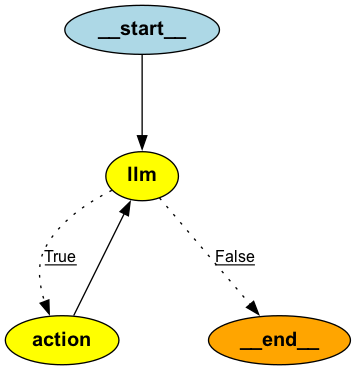

In [32]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [54]:
# messages = [HumanMessage(content="Does Kalamang use subject-verb-object order to subject-object-verb order?")]
# messages = [HumanMessage(content="How are negations formed in sentences in Kalamang?")]
# messages = [HumanMessage(content="How are plural forms of nouns constructed?")]
messages = [HumanMessage(content="What's the translation for island?")]


result = abot.graph.invoke({'messages': messages})

Calling: {'name': 'GrammarBookSearch', 'args': {'__arg1': 'island'}, 'id': 'call_MJoI06gS0yjECaOTs4Edlukj', 'type': 'tool_call'}
Back to the model!


In [55]:
result['messages'][-1].content

'The translation for "island" in the language is "Kalamang Island".'

In [ ]:
# Not sure what this was used for. keep it for now.

retriever = db_chroma.as_retriever()

from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
llm = ChatOpenAI(temperature=0.7)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    verbose=True
)